# Elastic Full Proc2D Means

In [1]:
#detach("package:elasdics2d", unload=TRUE)
devtools::install("../../elasdics")
library(elasdics2d)
library(ggplot2)
library(gridExtra)
library(dplyr)

# Display plots in smaller size
options(repr.plot.width=10, repr.plot.height=5)


v  checking for file 'D:\Dropbox\Statistik\elasdics/DESCRIPTION'
-  preparing 'elasdics2d': (1.5s)
v  checking DESCRIPTION meta-information
-  checking for LF line-endings in source and make files and shell scripts
-  checking for empty or unneeded directories
-  building 'elasdics2d_0.1.0.tar.gz'
   
Running "C:/R/R-4.0.5/bin/x64/Rcmd.exe" INSTALL \
  "C:\Users\manue\AppData\Local\Temp\RtmpghQfjB/elasdics2d_0.1.0.tar.gz" \
  --install-tests 
* installing to library 'C:/R/R-4.0.5/library'
* installing *source* package 'elasdics2d' ...
** using staged installation
** R
** tests
** byte-compile and prepare package for lazy loading
** help
No man pages found in package  'elasdics2d' 
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
*** arch - i386
*** arch - x64
** testing if installed package can be loaded from final location
*** arch - i386
*** arch - x64
** testing if installed package keeps a record of tempo


Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




ProcrustesLoad some datasets with random rotation and scaling.

In [2]:
source("../scripts/load_datasets.R")

normalize_curve <- function(curve) {
    dx = diff(curve$X1)
    dy = diff(curve$X2)
    dt = diff(curve$t)
    l = sum(sqrt(dx^2 + dy^2))
    curve$X1 = curve$X1 / l
    curve$X2 = curve$X2 / l
    curve
}

set.seed(18)

data_curves <- curves.spiral(n_curves=10, rotate=TRUE, scale=TRUE, center=TRUE)
data_curves2 <- curves.digit3(rotate=TRUE, scale=TRUE, center=TRUE)

data_curves <- lapply(data_curves, normalize_curve)
data_curves2 <- lapply(data_curves2, normalize_curve)

Take a look at the data curves.

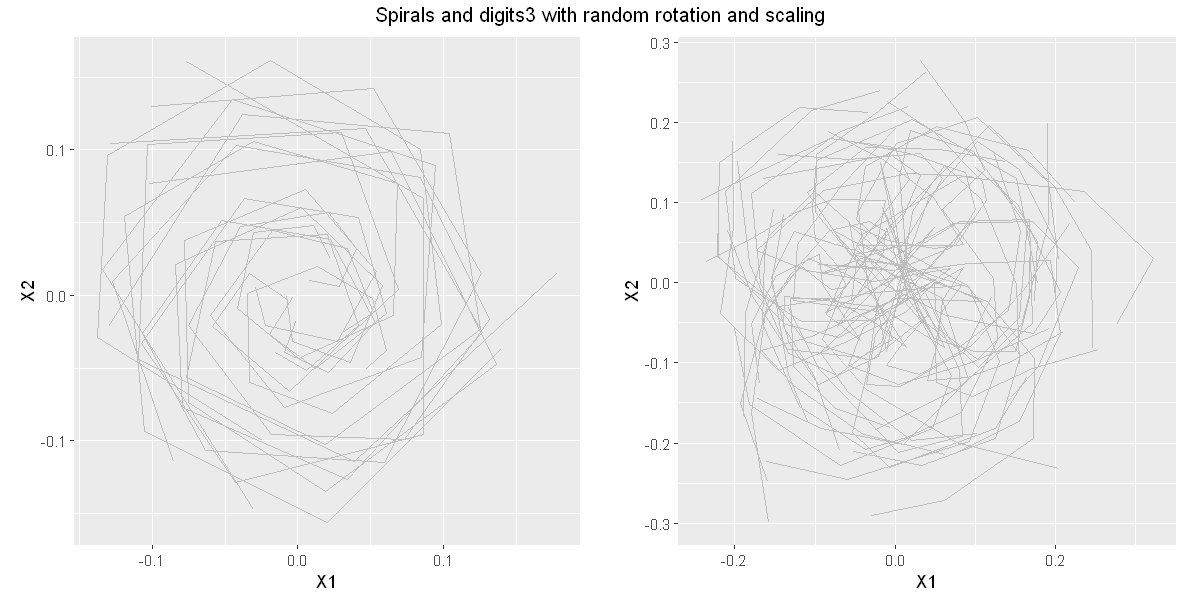

In [3]:
p1 <- ggplot(bind_rows(data_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

p2 <- ggplot(bind_rows(data_curves2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(size=0.5, aes(group=id), color="grey") +
    coord_fixed()

grid.arrange(p1, p2, nrow=1, top="Spirals and digits3 with random rotation and scaling")

Define function for Cov plotting.

In [4]:
plot_cov_surface<- function(cov_fit, h=0.01){
  # Define covariance surface grid (s,t).
  arg.grid = seq(0, 1, by=h)
  cov.grid = expand.grid(t = arg.grid, s = arg.grid)
  # Evaluate fit on grid.
  cov.re = predict(cov_fit$re, newdata = cov.grid)
  cov.im = predict(cov_fit$im, newdata = cov.grid)

  par(mfrow=c(1,2), mar=c(4,4,4,1), oma=c(0.5,0.5,0.5,0))
  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',
    main = 'Smoothed covariance surface (real part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.re, nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))

  # From 'fdapace/src/R/CreateCovPlot.R'
  args1 <- list(
    xlab='t', ylab='s', zlab = 'C(s,t)',

    main = 'Smoothed covariance surface (imaginary part)'
  )
  args2 = list (x = arg.grid, y = arg.grid, z = matrix(cov.im,nrow=101))
  do.call(plot3D::persp3D, c(args2, args1))
}

#### Calculate Smooth Elastic Mean

In [5]:
# Turn of warnings
defaultW <- getOption("warn")
options(warn = -1)

In [6]:
# Compute mean 'spirals'
type1 = "polygon"
knots1 <- seq(0,1, length = 13)
smooth_elastic_mean <- compute_elastic_mean(data_curves, knots = knots1, type = type1, 
                                            proc2d = TRUE, penalty = 0)
options(repr.plot.width=12, repr.plot.height=8)
plot_cov_surface(smooth_elastic_mean$cov_smooth_obj)

ERROR: Error in while (mean(ldxx/(ldxx + ldss)) > 0.4) {: missing value where TRUE/FALSE needed


In [ ]:
# Comput mean 'digits3'
type2 = "polygon"
knots2 <- seq(0,1, length = 3)
smooth_elastic_mean2 <- compute_elastic_mean(data_curves2, knots = knots2, type = type2,
                                             proc2d = TRUE, penalty = 0)
options(repr.plot.width=12, repr.plot.height=8)
plot_cov_surface(smooth_elastic_mean2$cov_smooth_obj)

In [ ]:
# Turn on warnings
options(warn = defaultW)

#### Plot Mean and Procrustes fits from Data curves via G,b

In [ ]:
pfits <- lapply(seq_along(data_curves), function(j){
    curve <- get_proc2d_from_param(
        data_curves[[j]],
        smooth_elastic_mean$G_optims[[j]],
        smooth_elastic_mean$b_optims[[j]]
    )
    center_curve(curve)
})

In [ ]:
pfits2 <- lapply(seq_along(data_curves2), function(j){
    curve <- get_proc2d_from_param(
        data_curves2[[j]],
        smooth_elastic_mean2$G_optims[[j]],
        smooth_elastic_mean2$b_optims[[j]]
    )
    center_curve(curve)
})

In [ ]:
knots_elasdics = if(type1 == "smooth") seq(0,1, length=11) else seq(0, 1, length=16)
mean1 <- compute_elastic_mean(pfits, knots = knots_elasdics, type = type1, proc2d = FALSE)
mean2 <- compute_elastic_mean(pfits2, knots = seq(0, 1, by=0.1), type = type2, proc2d = FALSE)

In [ ]:
p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    geom_path(data=get_evals(mean1), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

p2 <- ggplot(bind_rows(pfits2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=X2), color = "red", size = 1) +
    geom_path(data=get_evals(mean2), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

In [ ]:
p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean), aes(x=X1, y=X2), color = "red", size = 1) +
    geom_path(data=get_evals(mean1), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

p2 <- ggplot(bind_rows(pfits2, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2), aes(x=X1, y=X2), color = "red", size = 1) +
    geom_path(data=get_evals(mean2), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

#### Compare Elastic and Normal Mean on Procrustes Fits

In [ ]:
mean3 <- compute_elastic_mean(pfits, knots = knots_elasdics, type = type1, proc2d = FALSE, max_iter=0)
mean4 <- compute_elastic_mean(pfits2, knots = seq(0, 1, by=0.1), type = type2, proc2d = FALSE, max_iter=0)

In [ ]:
p1 <- ggplot(bind_rows(smooth_elastic_mean$procrustes_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(mean3, centering = TRUE), aes(x=X1, y=X2), color = "red", size = 1, linetype=2) +
    geom_path(data=get_evals(mean1, centering = TRUE), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

p2 <- ggplot(bind_rows(smooth_elastic_mean2$procrustes_curves, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(mean4, centering = TRUE), aes(x=X1, y=X2), color = "red", size = 1) +
    geom_path(data=get_evals(mean2, centering = TRUE), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

In [ ]:
dists <- lapply(seq(1:length(data_curves2)), function(j){
    al <- align_curves(get_evals(smooth_elastic_mean2), smooth_elastic_mean2$procrustes_curves[[j]])
    al$elastic_dist
})

In [ ]:
out <- which(dists %in% boxplot.stats(unlist(dists))$out)
p1 <- ggplot(bind_rows(pfits, .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean, centering = TRUE), aes(x=X1, y=X2), color = "red", size = 1) +
    geom_path(data=get_evals(mean1, centering = TRUE), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

p2 <- ggplot(bind_rows(pfits2[-out], .id="id"), aes(x=X1, y=X2)) + 
    geom_path(aes(group=id), size = 0.5, color="grey") +
    geom_path(data=get_evals(smooth_elastic_mean2, centering = TRUE), aes(x=X1, y=X2), color = "red", size = 1) +
    geom_path(data=get_evals(mean2, centering = TRUE), aes(x=X1, y=X2), color = "blue", size = 1, linetype=2) +
    coord_fixed()

options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p1, p2, nrow=1, top="Procrustes Data Curves and Mean")

In [ ]:
data_curves2 <- data_curves2[-out]

In [ ]:
out